In [1]:
import pandas as pd

In [10]:
df = pd.read_csv('arxiv.csv')
df.head()

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,title,categories
0,704.0033,Convergence of the discrete dipole approximati...,"['physics', 'optics']"
1,704.0038,The discrete dipole approximation: an overview...,"['physics', 'optics']"
2,704.0479,The affine part of the Picard scheme,"['math', 'AG']"
3,704.1476,TeV-scale gravity in Horava-Witten theory on a...,['hep-th']
4,705.1155,State Vector Determination By A Single Trackin...,['astro-ph']


In [11]:
def preprocess_categories(cat):
    cat = cat.replace('[', '')
    cat = cat.replace(']', '')
    cat = cat.replace("'", '')
    return cat

In [12]:
from tqdm import tqdm

tqdm.pandas()
df['processed_categories'] = df['categories'].progress_apply(preprocess_categories)

100%|██████████| 401806/401806 [00:00<00:00, 456456.19it/s]


In [13]:
df['concat'] = df['title'] + ' ' + df['processed_categories']

In [14]:
df.concat[0]

'Convergence of the discrete dipole approximation. I. Theoretical\n  analysis physics, optics'

### relevance matrix using Annotated Suffix Tree

In [15]:
titles = list()
for i in df.concat:
    titles.append(i)

In [16]:
import re
import numpy as np
from east.asts import base


def clear_text(text, lowerize=True):
    pat = re.compile(r'[^A-Za-z0-9 \-\n\r.,;!?А-Яа-я]+')
    cleared_text = re.sub(pat, ' ', text)
    if lowerize:
        cleared_text = cleared_text.lower()
    tokens = cleared_text.split()
    return tokens


def make_substrings(tokens, k=4):
    for i in range(max(len(tokens) - k + 1, 1)):
        yield ' '.join(tokens[i:i + k])


def get_relevance_matrix(texts, strings):
    matrix = np.empty((0, len(strings)), float)
    prepared_text_tokens = [clear_text(t) for t in texts]
    prepared_string_tokens = [clear_text(s) for s in strings]
    prepared_strings = [' '.join(t) for t in prepared_string_tokens]
    for text_tokens in prepared_text_tokens:
        ast = base.AST.get_ast(list(make_substrings(text_tokens)))
        row = np.array([ast.score(s) for s in prepared_strings])
        matrix = np.append(matrix, [row], axis=0)
    return matrix


def save_matrix(matrix):
    np.savetxt("relevance_matrix.txt", matrix)

In [17]:
with open("taxonomy_leaves.txt") as f:
    strings = [l.strip() for l in f.readlines()]

In [35]:
relevance_matrix = get_relevance_matrix(titles, strings)

In [36]:
save_matrix(relevance_matrix)

### fuzzy thematic clusters using FADDIS

In [ ]:
from faddis import faddis
from lapin import lapin
from operator import itemgetter

In [ ]:
tc = relevance_matrix.dot(relevance_matrix.T)

In [ ]:
tc_transformed = lapin(tc)

In [46]:
B, member, contrib, intensity, lat, tt = faddis(tc_transformed)

In [47]:
np.savetxt("clusters.dat", member)

In [52]:
for cluster in member.T:
    print(list(sorted(zip(titles, cluster.flat), key=itemgetter(1), reverse=True))[:5], '\n')

[('The affine part of the Picard scheme math, AG', 0.21819224121860334), ('An Alexandrov-Fenchel-type inequality in hyperbolic space with an\n  application to a Penrose inequality math, DG', 0.16103823115017746), ('On surfaces with zero vanishing cycles math, AG', 0.14406296969205243), ('Local Quasiconvexity of Groups acting on Small Cancellation Complexes math, GR', 0.1292030207502672), ('Dynamical determination of the basic Planck units physics, gen-ph', 0.1203616513053496)] 

[('Two-photon interferometry illuminates quantum measurements quant-ph', 0.18078862539264068), ('(Micro)detection of single photon interference at beam splitter quant-ph', 0.15619346119783087), ('Models of G-spectra as presheaves of spectra math, AT', 0.15439783670106744), ('State Vector Determination By A Single Tracking Satellite astro-ph', 0.14644832193428148), ('On the "pits effect" of Littlewood and Offord math, CV', 0.14127866647704024)] 

[('Finite p-Irregular Subgroups of PGL(2,k) math, NT', 0.204160859

Обобщим 0-й полученный кластер с параметрами LIMIT = 0,12 (порог принадлежности к кластеру), GAMMA = 0,9, LAMBDA = 0,075. Мы будем использовать модуль pargenfs.py от GoT:

In [7]:
!python3 GOT/build/lib/got/taxonomies/pargenfs.py Data_Science_taxonomy.csv taxonomy_leaves.txt clusters.dat 0

Number of leaves: 351
All positive weights:
unsupervised learning and clustering                         0.30259
bagging                                                      0.22333
web log analysis                                             0.17918
call level interfaces                                        0.16692
temporal difference learning                                 0.16576
reconstruction                                               0.15954
database query processing and optimization                   0.15463
semi-structured data                                         0.14744
anomaly detection                                            0.14296
anomaly detection                                            0.14296
treemaps                                                     0.13273
data encoding and canonicalization                           0.13255
query learning                                               0.13208
learning to rank                                           

Обобщение кластера 0.

In [13]:
!python3 GOT/build/lib/got/taxonomies/visualize.py taxonomy_tree_lifted.ete

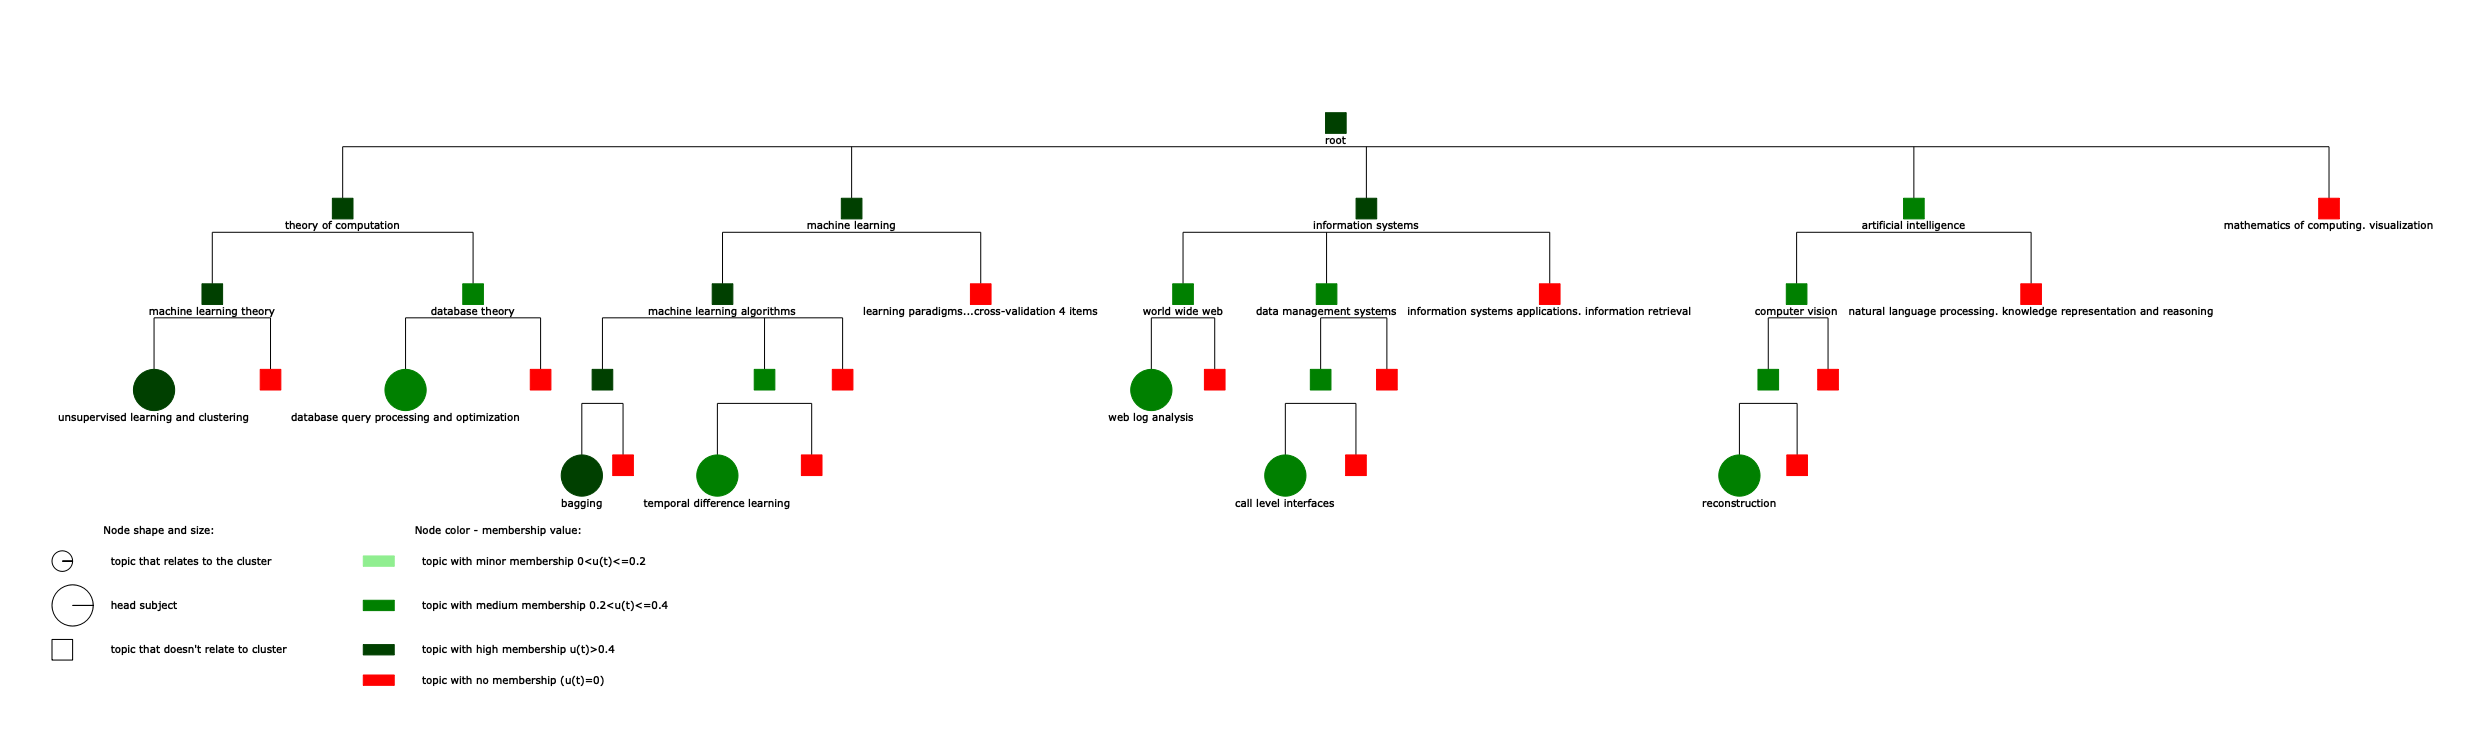

In [17]:
!python3 GOT/build/lib/got/taxonomies/pargenfs.py Data_Science_taxonomy.csv taxonomy_leaves.txt clusters.dat 1

Number of leaves: 351
All positive weights:
critical nodes detection                                     0.22428
description logics                                           0.22171
semi-supervised learning                                     0.20287
splittting criteria                                          0.17521
vagueness and fuzzy logic                                    0.17234
robust regression                                            0.16670
hierarchical representations                                 0.14923
distribution functions                                       0.14757
database interoperability                                    0.14617
bayesian networks                                            0.14463
site wrapping                                                0.13874
random number generation                                     0.13808
partially-observable markov decision processes               0.13680
dictionaries                                               

Обобщение кластера 1.

In [18]:
!python3 GOT/build/lib/got/taxonomies/visualize.py taxonomy_tree_lifted.ete

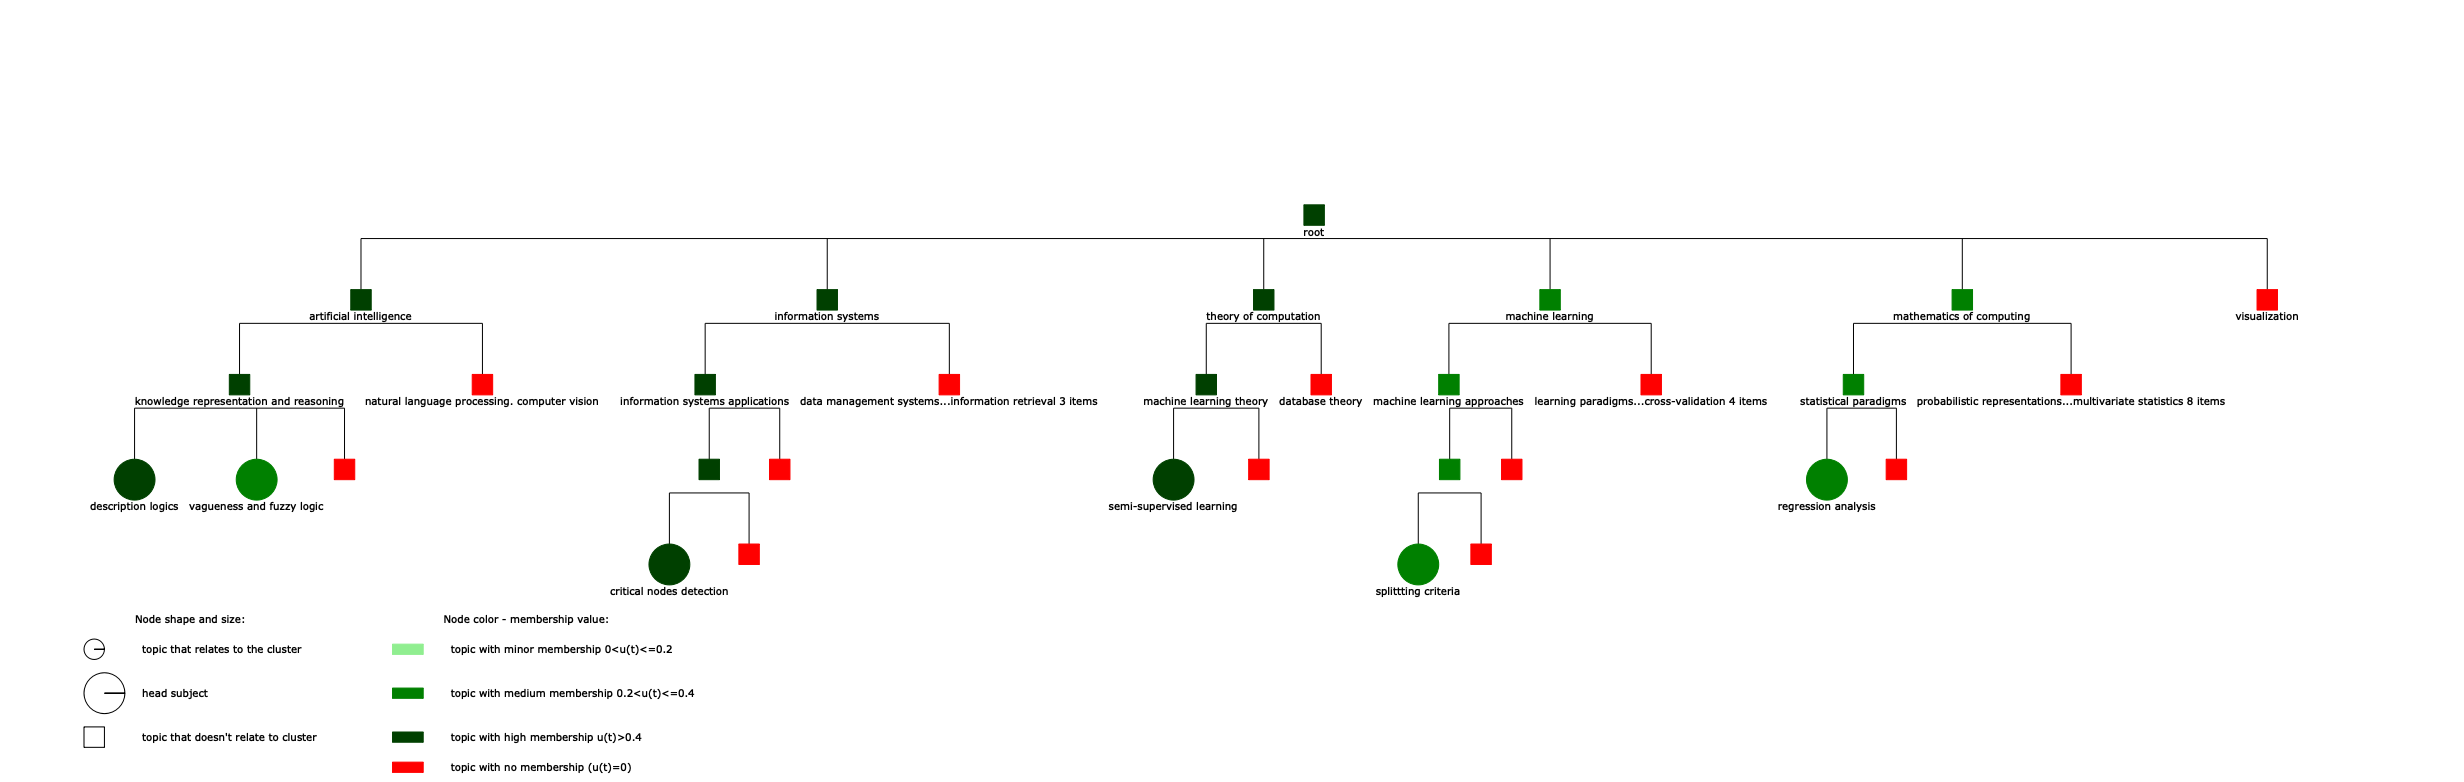

In [19]:
!python3 GOT/build/lib/got/taxonomies/pargenfs.py Data_Science_taxonomy.csv taxonomy_leaves.txt clusters.dat 2

Number of leaves: 351
All positive weights:
object recognition                                           0.27315
markov networks                                              0.21811
instance-based learning                                      0.19199
kernel matrix                                                0.17589
factor graphs                                                0.17412
top-k retrieval in databases                                 0.16552
tracking                                                     0.14870
active learning settings                                     0.14470
apprenticeship learning                                      0.14438
apprenticeship learning                                      0.14438
speech recognition                                           0.14272
search results deduplication                                 0.13818
temporal difference learning                                 0.13680
test collections                                           

Обобщение кластера 2.

In [21]:
!python3 GOT/build/lib/got/taxonomies/visualize.py taxonomy_tree_lifted.ete

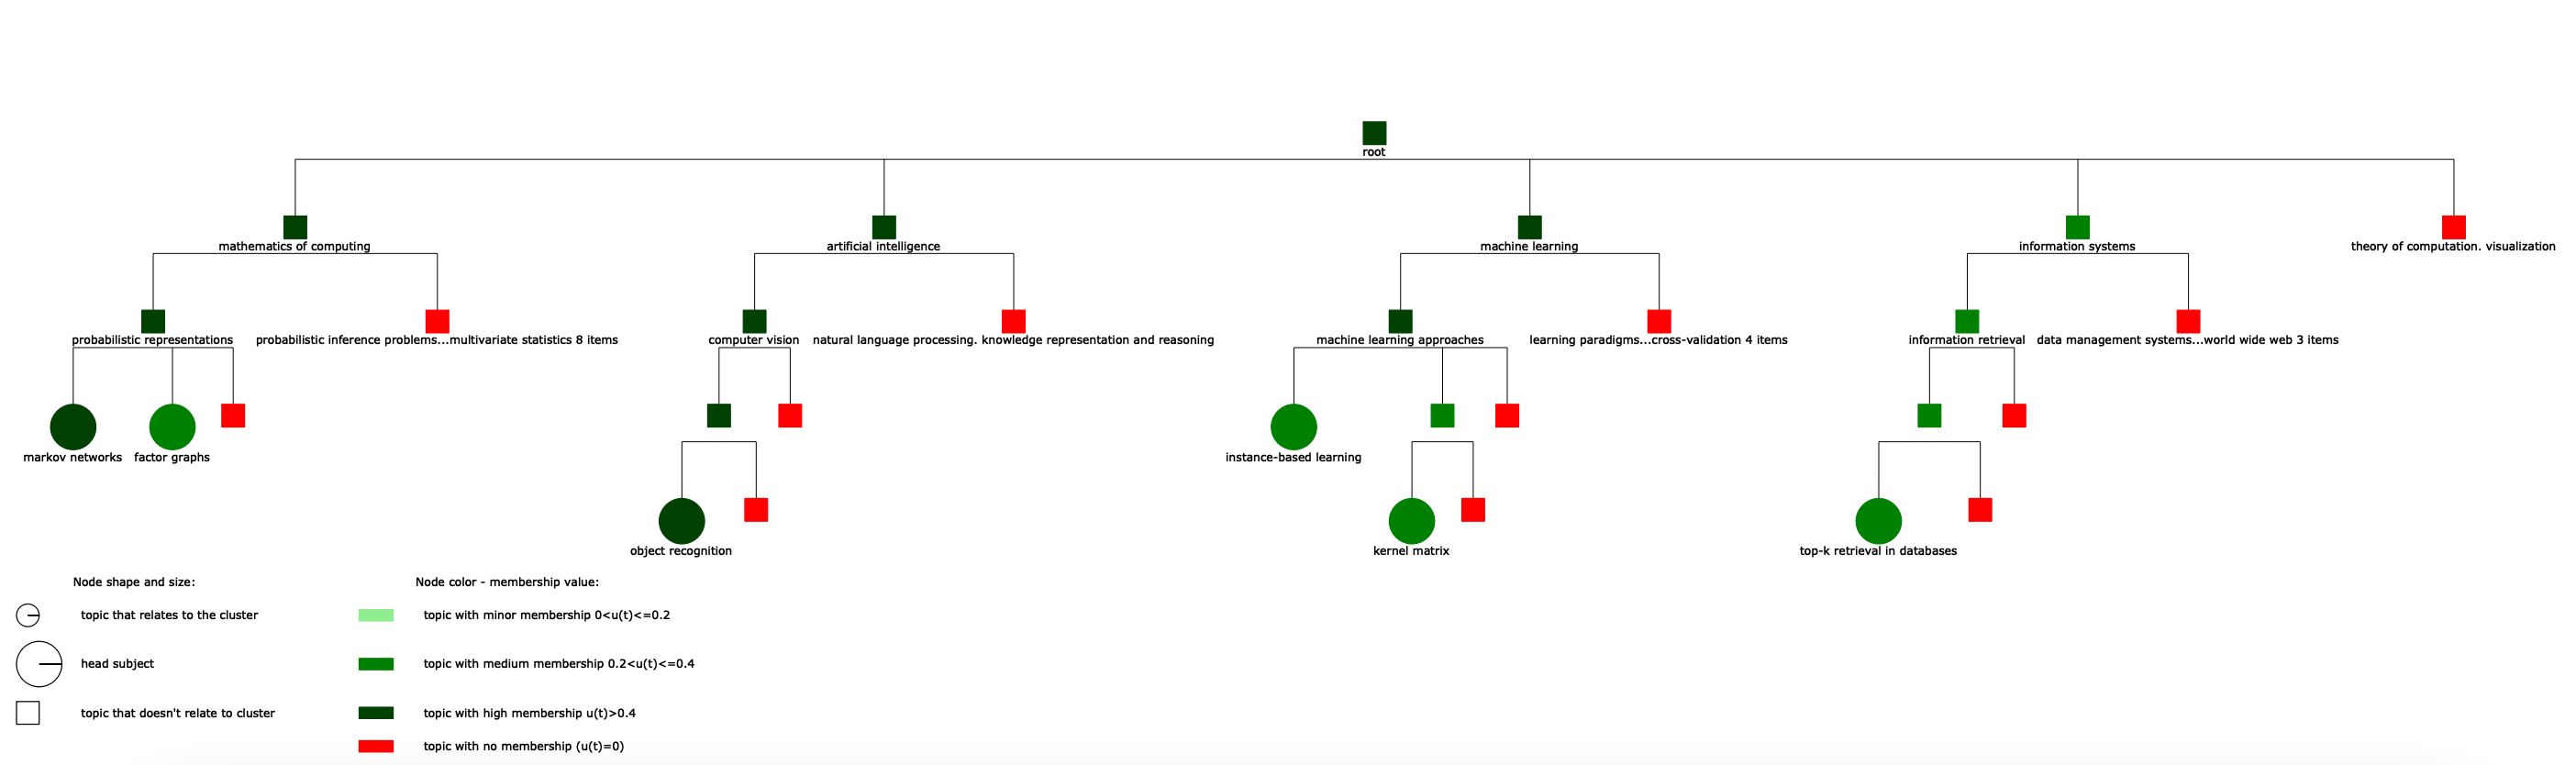

In [23]:
!python3 GOT/build/lib/got/taxonomies/pargenfs.py Data_Science_taxonomy.csv taxonomy_leaves.txt clusters.dat 3

Number of leaves: 351
All positive weights:
multiresolution                                              0.26311
bagging                                                      0.23962
simulated annealing                                          0.19922
multivariate statistics                                      0.19576
deep belief networks                                         0.17787
bootstrapping                                                0.17359
rule and pattern discovery                                   0.16632
batch learning                                               0.16611
graph drawings                                               0.16469
image search                                                 0.15682
sparse pca                                                   0.14599
formal concept analysis                                      0.14392
bayesian computation                                         0.14158
maximum entropy modeling                                   

ete representation saved in the file: taxonomy_tree_lifted.ete
ete representation saved.
Done.


Обобщение кластера 3

In [24]:
!python3 GOT/build/lib/got/taxonomies/visualize.py taxonomy_tree_lifted.ete

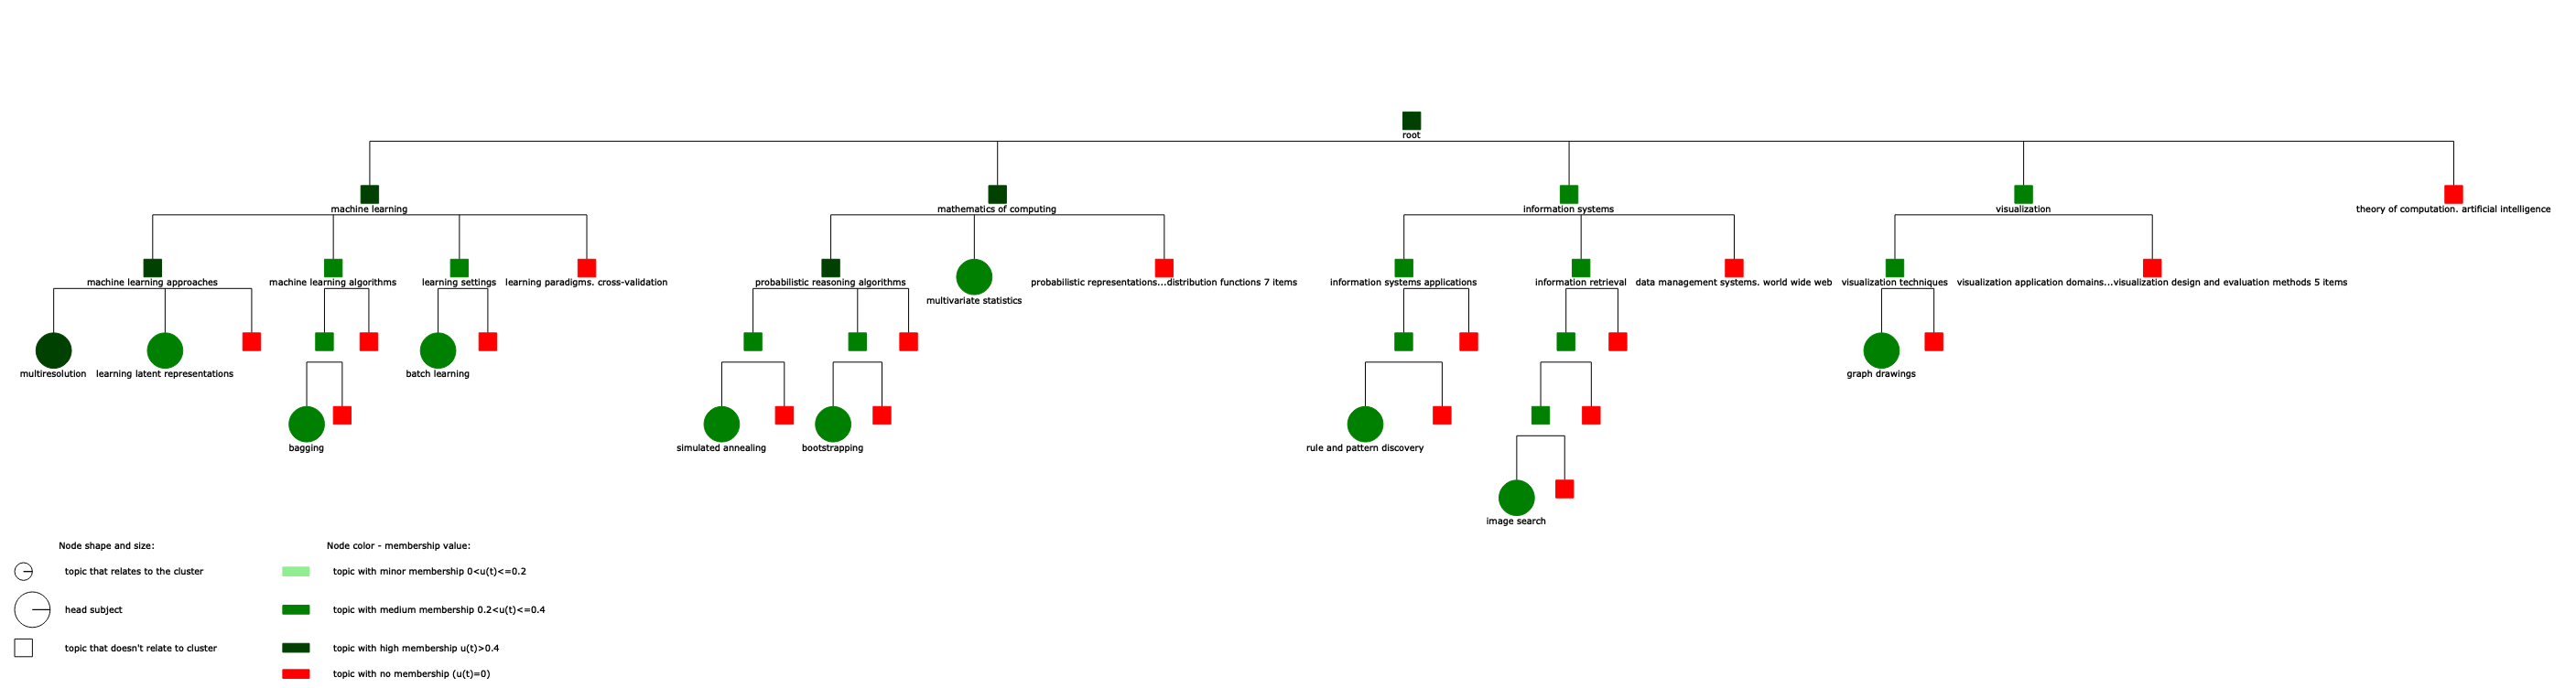

In [25]:
!python3 GOT/build/lib/got/taxonomies/pargenfs.py Data_Science_taxonomy.csv taxonomy_leaves.txt clusters.dat 4

Number of leaves: 351
All positive weights:
additive clustering                                          0.37009
deep web                                                     0.21250
perceptron algorithm                                         0.16658
dbms engine architectures                                    0.16078
expert search                                                0.15525
gaussian processes                                           0.15233
gaussian processes                                           0.15233
rule and pattern discovery                                   0.15126
triggers and rules                                           0.15014
description logics                                           0.14970
types of association rules                                   0.14231
stream management                                            0.14192
multiresolution                                              0.14172
hierarchical representations                               

Обобщение кластера 4

In [26]:
!python3 GOT/build/lib/got/taxonomies/visualize.py taxonomy_tree_lifted.ete

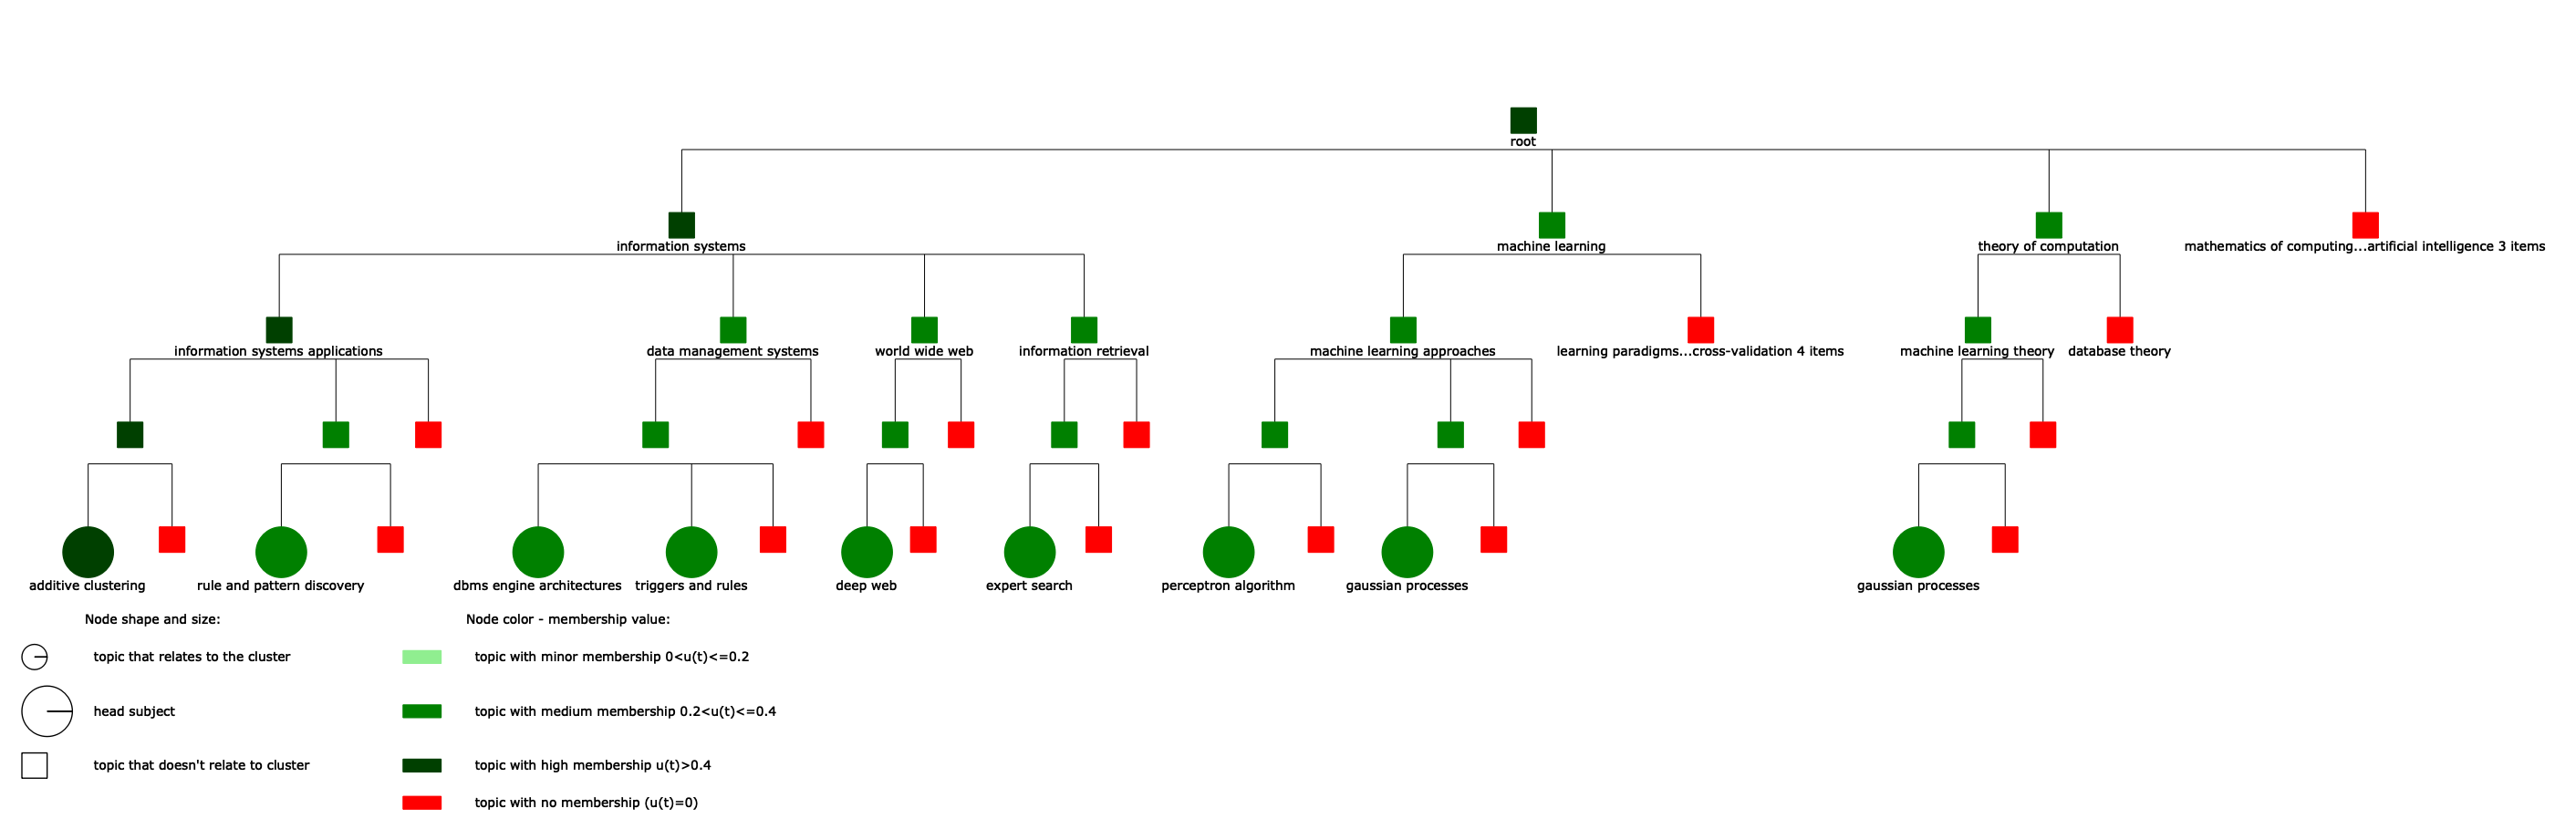

In [37]:
!python3 GOT/build/lib/got/taxonomies/pargenfs.py Data_Science_taxonomy.csv taxonomy_leaves.txt clusters.dat 5

Number of leaves: 351
All positive weights:
database interoperability                                    0.20562
temporal difference learning                                 0.19065
query learning                                               0.16882
multi-agent learning                                         0.16822
model trees                                                  0.15013
process mining                                               0.14717
loopy belief propagation                                     0.14554
multi-agent reinforcement learning                           0.14363
multi-agent reinforcement learning                           0.14363
test collections                                             0.14331
markov networks                                              0.14267
empirical studies in visualization                           0.14026
personalization                                              0.13962
instance-based learning                                    

Table saved in the file: table.csv
ete representation saved in the file: taxonomy_tree_lifted.ete
ete representation saved.
Done.


Обобщение кластера 5

In [38]:
!python3 GOT/build/lib/got/taxonomies/visualize.py taxonomy_tree_lifted.ete

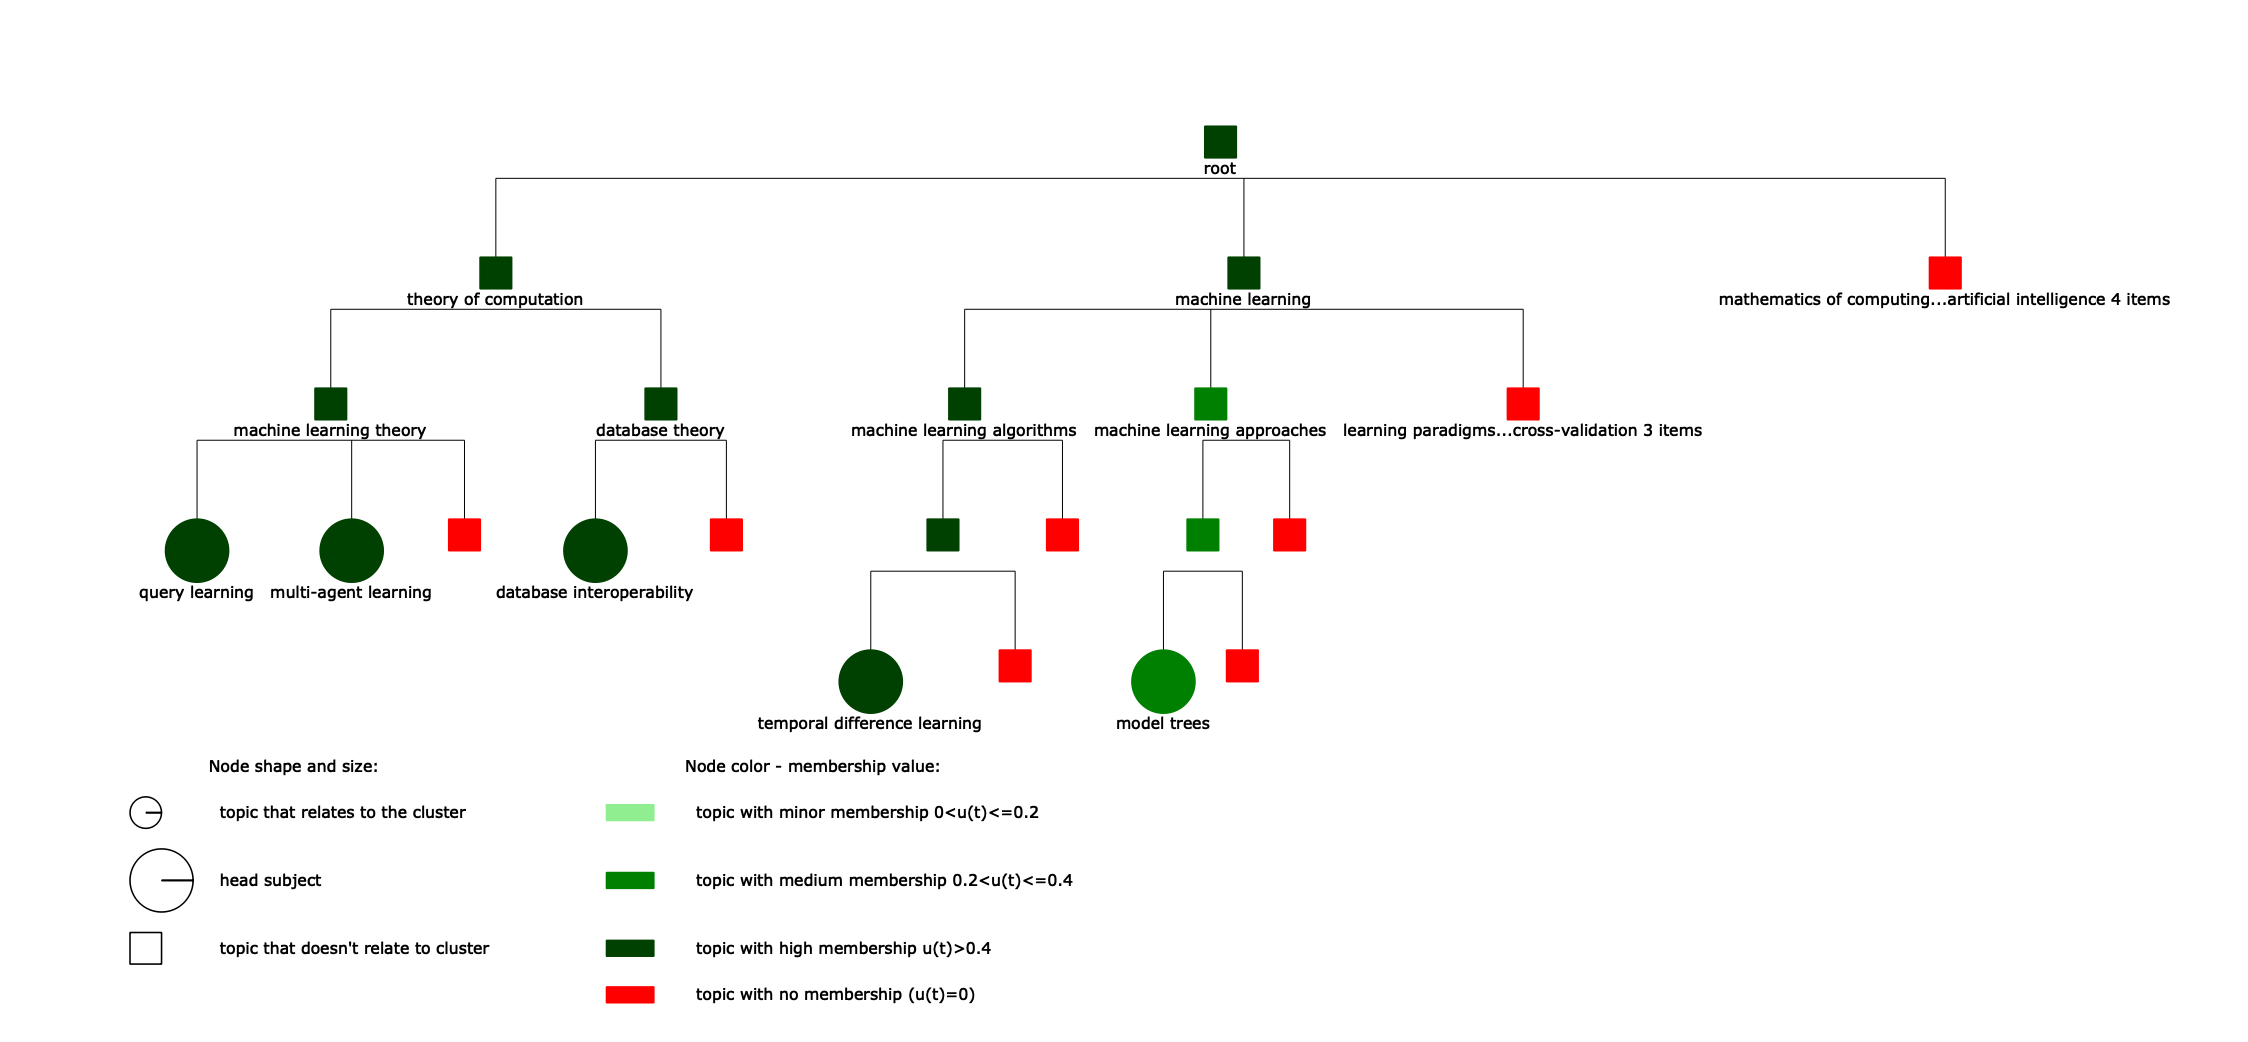

Проверка качества

In [1]:
from FuzzySilhouette import FuzzySilhouette

In [3]:
FuzzySilhouette(relevance_matrix, member, 6)

0.608971
